#Diffusion Model:
**It is a deep learning score based model,which generates high quality images by adding noise to an image progressively and learning the way to denoise the images, producing a high quality of images.**

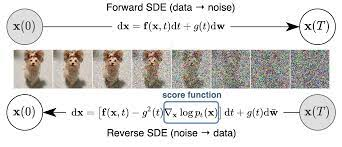


**Here, the image is added with the noise as shown above not all at once, but progressively recording every time step of noising these images, fundamentally destroying the image or the training data and learning through neural network to recover the data by reversing the noise process.**

#Stable Diffusion Model

**A state of the art model deals with denoising the images, which are combined with text prompt using U-Net model.**

**The description of this detailed work is given below, but let me tell you the brief description about the architecture of the system.**

**First of all Encoder is used for image to transfer image in latent space, and clip model is used for self attention or to find out the main points from the given prompt (basically, which part is given more attention than other part).**

**I have used VQ-VAE model to obtain a discrete latent representation, and later on during the decoding process of latent vectors we would replace this U-net output with codebook demonstrating the generative quality of VQ-VAE.**
**At last I have used discriminator for comparision of generated image and the real image, for better construction of those images.**

#Detail Programming explanation is attached to befor each row of coding

In [10]:
!pip install datasets

#Let's import some library

In [11]:
from datasets import load_dataset
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import math, re, copy
import warnings
import pandas as pd
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt


In [12]:
from PIL import Image
import numpy as np
import os

In [24]:
def get_dataframe(path):
  dataset = load_dataset(path)
  df_train = dataset['train'].to_pandas()
  return df_train

**I have used dataset from hugging face dataset for this training**

In [25]:
df = get_dataframe("poloclub/diffusiondb")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for poloclub/diffusiondb contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/poloclub/diffusiondb
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [26]:
df.head()

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
0,"{'bytes': None, 'path': '/root/.cache/huggingf...","portrait of kanye - west!!! fish hybrid, intri...",2024077420,125,13.0,k_lms,640,960,907fa43a9e86d003b31b8e7e12b5c88ca77ded59574758...,2022-08-14 20:41:00+00:00,0.160940,0.000900
1,"{'bytes': None, 'path': '/root/.cache/huggingf...",foto de mariano rajoy cyberpunk futurista,1653996999,50,7.0,k_lms,512,512,ebdfd201b608d6aee1a83391da734a95dab4c81e3f005b...,2022-08-14 20:42:00+00:00,0.401359,0.002851
2,"{'bytes': None, 'path': '/root/.cache/huggingf...","graffiti, shards of time, illustration, highly...",2495904409,50,15.0,k_lms,512,640,ffadfd44dadfe34aa663e97422fbe530fd5dac2292c9fd...,2022-08-14 20:42:00+00:00,0.065368,0.001689
3,"{'bytes': None, 'path': '/root/.cache/huggingf...",portrait of kanye - west!!! with a fish body!!...,2930267780,125,9.0,k_lms,512,512,907fa43a9e86d003b31b8e7e12b5c88ca77ded59574758...,2022-08-14 20:43:00+00:00,0.325422,0.002412
4,"{'bytes': None, 'path': '/root/.cache/huggingf...","handsome squidward portrait, van gogh art styl...",886405151,50,7.0,k_lms,512,512,70665e2a037a01f42dadb24d44356a08075ddf9d25e7e4...,2022-08-14 20:43:00+00:00,0.096831,0.042080


portrait of kanye - west!!! fish hybrid, intricate, extremely detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, ambient lighting, art by artgerm and greg rutkowski and alphonse mucha and simon stalenhag 


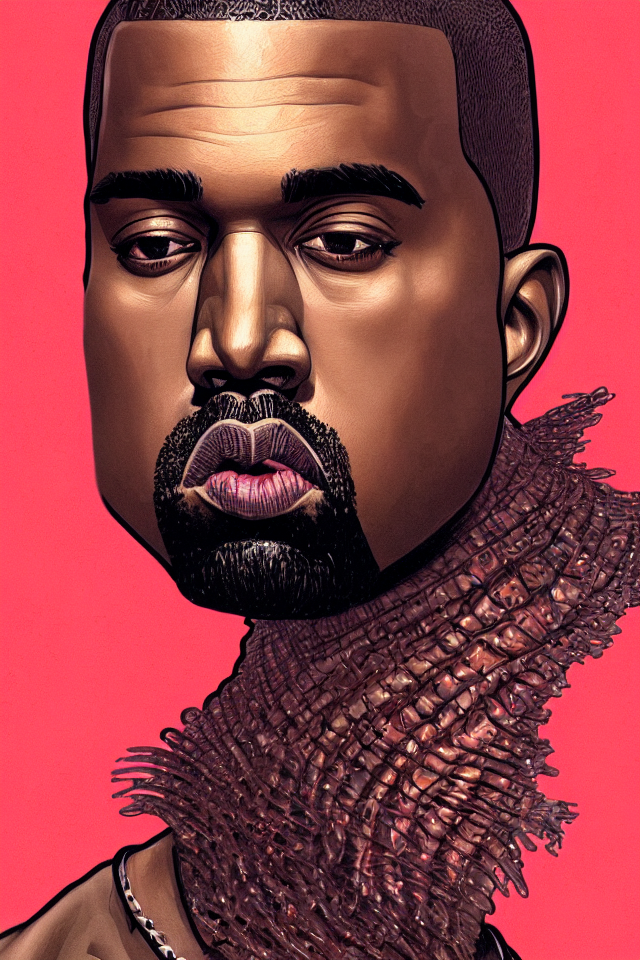

In [27]:
dir = df['image'][0]['path']

print(df['prompt'][0])
Image.open(dir)

**Converting Image into 224 X 224 image**

**I have resized the image into 224, 224 image size**

In [28]:
import torchvision.transforms as T
transform = T.Resize((224, 224))

In [ ]:
number_images = len(df)
print(number_images)

In [ ]:
def resize_image(path_2):
  for i in range(1000):
    path_1 = df['image'][i]['path']
    img = Image.open(path_1)
    img_r = transform(img)
    img_r_np = np.array(img_r)
    Image.fromarray(img_r_np).save(f"{path_2}image_{i}.png")

In [ ]:
path_2 = "/content/drive/MyDrive/MultiModal_Data_1/Image/"
resize_image(path_2)


In [ ]:
prompt_descr = list(df['prompt'])
print(prompt_descr[0])

joi from blade runner 2 0 4 9 as a giant pink skinned translucent hologram with blue hair, neo noire 


In [ ]:
len(path_2)

46

In [ ]:
folder_path = "/content/drive/MyDrive/MultiModal_Data_1/text/"
file_path = os.path.join(folder_path, 'descrition.txt')
with open(file_path, 'w') as file:
  for value in prompt_descr:
    file.write(value + '\n')

In [ ]:
with open("/content/drive/MyDrive/Text_to_image(text)/Text/descrition.txt", 'r') as f:
  content = f.readlines()
prompt = [line.strip() for line in content]

**Let's open the image and see the respective prompt**

#ENCODER

**Residual Block for VAE**

In [29]:
class VAEResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm_1 = nn.GroupNorm(32, in_channels)
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.groupnorm_2 = nn.GroupNorm(32, out_channels)
    self.conv2 = nn.Conv2d(out_channels ,out_channels, kernel_size=3, padding=1)
    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
  def forward(self, x):
    residue = x
    x = self.groupnorm_1(x)
    x = F.silu(x)
    x = self.conv_1(x)
    x = self.groupnorm_2(x)
    x = F.silu(x)
    x = self.conv_2(x)
    return x+ self.residual_layer(residue)

**AttentionBlock for VAE**

In [30]:
class VAE_AttentionBlock(nn.Module):
  def  __init__(self, channels):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, channels)
    self.attention = SelfAttention(1, channels)
  def forward(self, x):
    residue = x
    x = self.groupnorm(x)
    n, c, h, w = x.shape
    x = x.view(n, c, h*w)
    x = x.transpose(-1, -2)
    x = self.attention(x)
    x = x.transpose(-1, -2)
    x = x.view((n, c, h, w))
    x += residue
    return x




**Encoder are like probabilistic modeling, which maps out image into some latent space, which is stochastic, which is a Gaussian probability density. A standard deviation and mean value is taken from the latent space and noise is added to make the probability distribution more expansive. The noise in a VAE arises naturally from the stochastic sampling process used to generate latent representations during training and inference.**  

In [31]:
class VAE_Encoder(nn.Sequential):
  def __init__(self):
    super().__init__(
        nn.Conv2d(3, 128, kernel_size=3, padding=1),
        VAEResidualBlock(128, 128),
        VAEResidualBlock(128, 128),
        nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
        VAEResidualBlock(128, 256),
        VAEResidualBlock(256, 256),
        nn.Conv2d(256, 256, kernel_siz=3, stride=2, padding=0),
        VAEResidualBlock(256, 512),
        VAEResidualBlock(512, 512),
        nn.Conv2d(512, 512,  kernel_size=3, stride=2, padding=0),
        VAEResidualBlock(512, 512),
        VAEResidualBlock(512, 512),
        VAEResidualBlock(512, 512),
        VAE_AttentionBlock(512),
        VAEResidualBlock(512, 512),
        nn.GroupNorm(32, 512),
        nn.SiLU(),
        nn.Conv2d(512, 8, kernel_size=1, padding=0),
        nn.Conv2d(8, 8, kernel_size=1, padding=0),
    )

  def forward(self, x, noise):

    for module in self:
      if getattr(module, 'stride', None) == (2, 2):
        x = F.pad(0, 1, 0, 1)
      x = module(x)
    mean, log_variance = torch.chunk(x, 2, dim=1)
    log_variance = torch.clamp(log_variance, -30, 20)
    variance = log_variance.exp()
    stdev = variance.sqrt()
    x = mean + stdev * noise
    x += 0.18215
    return x

#CLIP Embedding Model

**We define both self and cross attention in clip model to add noise in latent space with the use of U-NeT model.**

**Let's first define attention model**

**SELF_Attention Model**

In [32]:
class SelfAttention(nn.Module):
  def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
    super().__init__()
    self.in_proj = nn.Linear(d_embed, 3*d_embed, bias=in_proj_bias)
    self.out_proj = nn.Linear(d_embed, d_embed, bias = out_proj_bias)
    self.n_heads = n_heads
    self.d_head = d_embed // n_heads
  def forward(self, x, causal_mask=False):
    input_shape = x.shape
    batch_size, sequence_length, d_embed = input_shape
    interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)
    q, k, v = self.in_proj(x).chunk(3, dim=-1)
    q = q.view(interim_shape).transpose(1, 2)
    k = k.view(interim_shape).transpose(1, 2)
    v = v.view(interim_shape).transpose(1, 2)
    weight = q@k.transpose(-1, -2)
    if causal_mask:
      mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
      weight.masked_fill_(mask, -torch.inf)
    weight /= math.sqrt(self.d_head)
    weight = F.softmax(weight, dim=-1)
    output = weight@v
    output = output.transpose(1, 2)
    output = output.reshape(input_shape)
    output = self.out_proj(output)
    return output


**Cross Attention: taking both image and text in the loop**

**It is done to find out or capture the important information which deals with both the text and

In [33]:
class CrossAttention(nn.Module):
  def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
    super().__init__()
    self.q_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
    self.k_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
    self.v_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
    self.out_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
    self.n_heads = n_heads
    self.d_head = d_embed // n_heads
  def forward(self, x, y):
    input_shape = x.shape
    batch_size, sequence_length, d_embed = input_shape
    interim_shape = (batch_size, -1, self.n_heads, self.d_head)
    q = self.q_proj(x)
    k = self.k_proj(y)
    v = self.v_proj(y)
    q = q.view(interim_shape).tranpose(1, 2)
    k = k.view(interim_shape).transpose(1, 2)
    v = v.view(interim_shape).transpose(1, 2)
    weight = q @ k.transpose(-1, -2)
    weight /= math.sqrt(self.d_head)
    weight = F.softmax(weight, dim=-1)
    output = weight @ v
    output = output.view(input_shape)
    output = self.out_proj(output)
    return output

#Now is the time for CLIP model


**Here, we use CLIP model for self attention over the words like transformer for the given prompt**

**Here we will use the CLIP Layer for self attention. Here self attention means, prioritizing the important part in a while diving through different words in a sequence.**

**During the analysis of prompt we use the self attention to highlight the important portion of the text, to get its embedding and use it while training or adding the noise in a time step**



In [34]:
class ClipEmbedding(nn.Module):
  def __init__(self, n_vocab: int, n_embed: int, n_token: int):
    super().__init__()
    self.token_embedding = nn.Embedding(n_vocab, n_embed)
    self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embed)))
  def forward(self, tokens):
    x = self.token_embedding(tokens)
    x +=  self.position_embedding
    return x

In [35]:
class CLIPLayer(nn.Module):
  def __init__(self, n_head: int, n_embed: int):
    self.layernorm_1 = nn.LayerNorm(n_embed)
    self.attention = SelfAttention(n_head, n_embed)
    self.layernorm_2 = nn.LayerNorm(n_embed)
    self.linear_1 = nn.Linear(n_embed, 4*n_embed)
    self.linear_2 = nn.Linear(4*n_embed, n_embed)
  def forward(self, x):
    residue = x
    x = self.layernorm_1(x)
    x = self.attention(x, causal_mask=True)
    x += residue
    residue = x
    x = self.layernorm_2(x)
    x = self.linear_1(x)
    x = x * torch.sigmoid(1.702 * x)
    x = self.linear_2(x)
    x += residue
    return x



In [36]:
class CLIP(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = ClipEmbedding(49408, 768, 77)
    self.layers = nn.ModuleList([
        CLIPLayer(12, 768) for i in range(12)
    ])
    self.layernorm = nn.LayerNorm(768)

  def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
    tokens = tokens.type(torch.long)
    state = self.embedding(tokens)
    for layer in self.layers:
      state = layer(state)
    output = self.layernorm(state)
    return output



#VAE_Decoder

**let's first define Decoder for Variational AutoEncoders**

In [37]:
class VAE_Decoder(nn.Sequential):
  def __init__(self):
    super().__init__(
        nn.Conv2d(4, 4, kernel_size=1, padding=0),
        nn.Conv2d(4, 512, kernel_size=3, padding=1),
        VAEResidualBlock(512, 512),
        VAE_AttentionBlock(512),
        VAEResidualBlock(512, 512),
        VAEResidualBlock(512, 512),
        VAEResidualBlock(512, 512),
        VAEResidualBlock(512, 512),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        VAEResidualBlock(512, 256),
        VAEResidualBlock(256, 256),
        VAEResidualBlock(256, 256),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        VAEResidualBlock(256, 128),
        VAEResidualBlock(128, 128),
        VAEResidualBlock(128, 128),
        nn.GroupNorm(32, 128),
        nn.SiLU(),
        nn.Conv2d(128, 3, kernel_size=3, padding=1)
    )

  def forward(self, x):
    x /= 0.18215
    for module in self:
      x = module(x)
    return x

#UNET Model Sampler:

**We use UNET to add noise at each step of the layer. Later in generate section we have used strength to create the strength of the noise, which is created at different timesteps where different layer of noise is added with text embedding from the clip layer, and image latent vector from the Encoder layer with different layers of noise is added according to the time embedding.**

**Later after bottleneck we use the UNET_Decoder layer to filter the image from the noise or to produce the latent vector removing all the noises and this is done in each layer of UNET Decoder.**

In [38]:
class TimeEmbedding(nn.Module):
  def __init__(self, n_embed):
    super().__init__()
    self.linear_1 = nn.Linear(n_embed, 4*n_embed)
    self.linear_2 = nn.Linear(4*n_embed, 4*n_embed)
  def forward(self, x):
    x = self.linear_1(x)
    x = F.SiLU(x)
    x = self.linear_2(x)
    return x

**let's make the residual and attention block for UNET Model and diffusion**

In [39]:
class UNET_residualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, n_time=1200):
    super().__init__()
    self.groupnorm_feature = nn.GroupNorm(32, in_channels)
    self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.linear_time = nn.Linear(n_time, out_channels)
    self.groupnorm_merged = nn.GroupNorm(32, out_channels)
    self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

  def forward(self, feature, time):
    residue = feature
    feature = nn.groupnorm_feature(feature)
    feature = F.SiLU(feature)
    feature = self.conv_feature(feature)
    time = self.SiLU(time)
    time = self.linear_time(time)
    merged = feature + time.unsqueeze(-1).unsqueeze(-1)
    merged = self.groupnorm_merged(merged)
    merged = F.SiLU(merged)
    merged = self.conv_merged(merged)
    return merged + self.residual_layer(residue)


In [40]:
from typing_extensions import Self
class UNET_AttentionBlock(nn.Module):
  def __init__(self, n_head: int, n_embed:int, d_context=768):
    super().__init__()
    channels = n_head * n_embed
    self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
    self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)
    self.layernorm_1 = nn.LayerNorm(channels)
    self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
    self.layernorm_2 = nn.LayerNorm(channels)
    self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)
    self.layernorm_3 = nn.LayerNorm(channels)
    self.linear_geglu_1 = nn.Linear(channels ,4*channels*2)
    self.linear_geglu_2 = nn.Linear(4*channels, channels)
    self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

  def forward(self, x, context):
    residue_long = x
    x = self.groupnorm(x)
    x = self.conv_input(x)
    n, c, h, w = x.shape
    x = x.view(n, c, h*w)

    x = x.transpose(-1, -2)
    residue_short = x
    x = self.layernorm_1(x)
    x += residue_short
    residue_short = x
    x = self.layernorm_2(x)
    self.attention_2(x, context)
    x += residue_short
    residue_short = x
    x = self.layernorm_3(x)
    x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)
    x = x*F.gelu(gate)
    x += residue_short
    x = x.transpose(-1, -2)
    x = x.view(n, c, h, w)
    return self.conv_output(x) + residue_long





In [41]:

class UNET(nn.Module):
  def __init__(self):
    super.__init__()
    self.encoders = nn.Module([
        SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding=1)),
        SwitchSequential(UNET_residualBlock(320, 320), UNET_AttentionBlock(8, 40)),
        SwitchSequential(UNET_residualBlock(320, 320), UNET_AttentionBlock(8, 40)),
        SwitchSequential(nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=1)),
        SwitchSequential(UNET_residualBlock(320, 640), UNET_AttentionBlock(8, 80)),
        SwitchSequential(UNET_residualBlock(640, 640), UNET_AttentionBlock(8, 80)),
        SwitchSequential(nn.Conv2d(640, 640, kernel_size=3, stride=2, padding=1)),
        SwitchSequential(UNET_residualBlock(640, 1280), UNET_AttentionBlock(8, 160)),
        SwitchSequential(UNET_residualBlock(1280, 1280), UNET_AttentionBlock(8, 160)),
        SwitchSequential(nn.Conv2d(1280, 1280, kernel_size=3, stride=2, padding=1)),
        SwitchSequential(UNET_residualBlock(1280, 1280)),
        SwitchSequential(UNET_residualBlock(1280, 1280))
        ])

    self.bottleneck = SwitchSequential(
        UNET_residualBlock(1280, 1280),
        UNET_AttentionBlock(8, 160),
        UNET_residualBlock(1280, 1280),
    )

    self.decoders = nn.Module([
        SwitchSequential(UNET_residualBlock(2560, 1280)),
        SwitchSequential(UNET_residualBlock(2560, 1280)),
        SwitchSequential(UNET_residualBlock(2560, 1280), Upsample(1280)),
        SwitchSequential(UNET_residualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
        SwitchSequential(UNET_residualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
        SwitchSequential(UNET_residualBlock(1920, 1280), UNET_AttentionBlock(8, 160), UpSample(1280)),
        SwitchSequential(UNET_residualBlock(1920, 640), UNET_AttentionBlock(8, 80)),
        SwitchSequential(UNET_residualBlock(1280, 640), UNET_AttentionBlock(8, 80)),
        SwitchSequential(UNET_residualBlock(960, 640), UNET_AttentionBlock(8, 80), Upsample(640)),
        SwitchSequential(UNET_residualBlock(960, 320), UNET_AttentionBlock(8, 40)),
        SwitchSequential(UNET_residualBlock(640, 320), UNET_AttentionBlock(8, 80)),
        SwitchSequential(UNET_residualBlock(640, 320), UNET_AttentionBlock(8, 40)),


    ])

In [42]:
class SwitchSequential(nn.Sequential):
  def forward(self, x:torch.Tensor, context:torch.Tensor, time:torch.Tensor) -> torch.Tensor:
    for layer in self:
      if isinstance(layer, UNET_AttentionBlock):
        x = layer(x, context)
      elif isinstance(layer, UNET_residualBlock):
        x = layer(x, time)
      else:
        x = layer(x)
    return x


In [43]:
class Upsample(nn.Module):
  def __init__(self, channels: int):
    super().__init__()
    self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
  def forward(self, x):
    x = F.interpolate(x, scale_factor=2, mode="nearest")
    return self.conv(x)

In [44]:
class UNET_OutputLayer(nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, in_channels)
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
  def forward(self, x):
    x = self.groupnorm(x)
    x = F.silu(x)
    x = self.conv(x)
    return x

In [45]:
width = 512
height = 512
latent_width = width // 8
latent_height = height // 8
# strength = [0.2, 0.4, 0.6, 0.8]

In [46]:
class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET()
        self.final = UNET_OutputLayer(320, 4)

    def forward(self, latent, context, time):

        time = self.time_embedding(time)


        output = self.unet(latent, context, time)


        output = self.final(output)


        return output

#VQ-VAE Implementation

**Here, as mentioned above VQ-VAE is used to index the codebook according to the embedding layer, and later after the latent vector is generated from diffusion layer. We use Vector Quantization to replace it with nearest embedding vector.**

In [47]:
class vector_q(nn.Module):
  def __int__(self, num_embeddings, embedding_dim, commitment_cost):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.num_embeddings = num_embeddings
    self.token_embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
    self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost
  def forward(self, inputs):
    inputs = inputs.permute(0, 2, 3, 1).contiguous()
    input_shape = inputs.shape
    flatten_input = inputs.view(-1, self.embedding_dim)
    distances = torch.sum(flatten_input**2, dim=1, keepdim=True)+torch.sum(self.embedding.weight**2,dim=1)-2 * torch.matmul(flatten_input, self.embedding_weight.t())

    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
    encodings.scatter_(1, encoding_indices, 1)
    quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)
    e_latent_loss = F.mse_loss(quantized.detach(), inputs)
    q_latent_loss = F.mse_loss(quantized, inputs.detach())
    loss = q_latent_loss + self.commitment_cost * e_latent_loss
    quantized = inputs + (quantized - inputs).detach()
    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
    return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings, encoding_indices

#DDPM Sampler


**We make a DDPM sampler for adding each time step for adding noise and we want to know the percentage addition of noise in the image at any timestep.**

**We have done the same thing we have recorded the addition of noise in the image at every time step.**

**This is done according to the DDPM paper.**

In [48]:
class DDPMSampler:
  def __init__(self, generator: torch.Generator, num_training_step=1000, beta_start: float=0.00085, beta_end: float=0.0120):
    self.betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_training_step, dtype=torch.float32) ** 2
    self.alphas = 1.0 - self.betas
    self.alpha_cumprod = torch.cumprod(self.alphas, 0)
    self.one = torch.tensor(1.0)
    self.generator = generator
    self.num_training_step = num_training_step
    self.timesteps = torch.from_numpy(np.arange(0, num_training_step)[::-1].copy())

  def self_inference_timesteps(self, num_inference_steps=50):
    step_ratio = self.num_training_step // self.num_inference_steps
    timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astyep(np.int64)
    self.timesteps = torch.from_numpy(timesteps)


  def _get_variance(self, timestep: int) -> torch.Tensor:
    prev_t = self._get_previous_timestep(timestep)
    alpha_prod_t = self.alpha_cumprod[timestep]
    alpha_prod_t_prev = self.alpha_cumprod[prev_t] if prev_t >= 0 else self.one
    current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev
    variance = (1-alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t
    variance = torch.clamp(variance, min=1e-20)
    return variance

  def _get_previous_timestep(self, timestep: int) -> int:
    prev_t = timestep  - (self.num_training_step // self.num_training_steps)
    return prev_t

  def step(self, timestep: int, latents: torch.Tensor, model_output: torch.Tensor):
    t = timestep
    prev_t = self._get_previous_timestep(t)

    alpha_prod_t = self.alpha_cumprod[timestep]
    alpha_prod_t_prev = self.alpha_cumprod[prev_t] if prev_t >=0 else self.one
    beta_prod_t = 1-alpha_prod_t
    beta_prod_t_prev = 1-alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1-current_alpha_t

    #Compute the predicted original sample using formula (15) of the DDPM paper

    pred_original_sample = ((latents - beta_prod_t ** 0.5) * model_output) / alpha_prod_t ** 0.5

    #Compute teh coefficients for the pred_original_sample and current_sample x_t
    pred_original_sample_coeff = (alpha_prod_t_prev**0.5 * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** 0.5 * beta_prod_t_prev / beta_prod_t
    #Compute the predicted previous sample mean
    predicted_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * latents

    variance = 0
    if t>0:
      device = model_output.device
      noise = torch.randn(model_output.shape, generator = self.generator, device=device, dtype=model_output.dtype)
      variance = (self._get_variance(t) ** 0.5) * noise
    #N(0, 1) --> N(mu, sigma^2)
    #X = mu + sigma*Z, where Z ~ N(0, 1)
    pred_prev_sample = pred_prev_sample + variance
    return pred_prev_sample



  def set_strength(self, strength):
    start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
    self.timesteps = self.timesteps[start_step:]
    self.start_step = start_step

  def add_noise(self, original_samples: torch.FloatTensor, timesteps:torch.IntTensor) -> torch.FloatTensor:
    alpha_cumprod = self.alpha_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
    timesteps = timesteps.to(original_samples.device)
    sqrt_alpha_prod = alpha_cumprod[timesteps] ** 0.5
    sqrt_alpha_prod = sqrt_alpha_prod.flatten()
    while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
      sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)
    sqrt_one_minus_alpha_prod = (1-alpha_cumprod[timesteps]) ** 0.5
    sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
    while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
      sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)
    #Equation 4 of ddpm paper

    noise = torch.randn(original_samples.shape, generator=self.generator, device=original_samples.device, dtype=original_samples.dtype)
    noisy_samples = (sqrt_alpha_prod * original_samples) + (sqrt_one_minus_alpha_prod) * noise
    return noisy_samples



In [49]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

#**Now Coding a pipeline to make the whole code generate new image**

In [69]:
def generate(prompt, input_image=None, uncond_prompt=None, strength=0.8, do_cfg=True, cfg_scale=7.5,
             sampler_name="ddpm", n_inference_steps=50, models={}, seed=None, device=None, idle_device=None, tokenizer=None):
  with torch.no_grad():
    if not 0 < strength <= 1:
      raise ValueError("Strength must be between 0 and 1.")
    if idle_device:
      to_idle = lambda x: x.to(device)
    else:
      to_idle = lambda x: x
    generator = torch.Generator(device=device)
    if seed is None:
      generator.seed()
    else:
      generator.manual_seed(seed)
    clip = models["clip"]
    clip.to(device)
    if do_cfg:
      cond_tokens = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77).input_ids
      cond_tokens = torch.tensor(cond_tokens, dtype=torch.long, device=device)
      cond_context = clip(cond_tokens)
      uncond_tokens = torch.batch_encode_plus([uncond_prompt], padding="max_length", max_length = 77).input_ids
      uncond_context = clip(uncond_tokens)
      context = torch.cat([cond_context, uncond_context])
    else:
      tokens = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77).input_ids
      tokens = torch.tensor(tokens, dtype=torch.long, device=device)
      context = clip(tokens)
    to_idle(clip)

    if sampler_name == "ddpm":
      sampler = DDPMSampler(generator)
      sampler.set_inference_timesteps(n_inference_steps)
    else:
      raise ValueError("Unknown sampler value %s.")
    latent_shape = (1, 4, latent_height, latent_width)
    if input_image:
      encoder = models["encoder"]
      encoder.to(device)
      input_image_tensor = input_image.resize((width, height))
      input_image_tensor = np.array(input_image_tensor, dtype=torch.float32)
      input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float32)
      input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))
      input_image_tensor = input_image_tensor.unsqueeze(0)
      input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)
      encoder_noise = torch.randn(latent_shape, generator=generator, device=device)
      latents = encoder(input_image_tensor, encoder_noise)
      sampler.set_strength(strength=strength)
      latents = sampler.add_noise(latents, sampler.timesteps[0])
      to_idle(encoder)
    else:
      latents = torch.randn(latent_shape, generator=generator, device=device)
    diffusion = models["diffusion"]
    diffusion.to(device)
    timesteps = tqdm(sampler.timesteps)
    for i, timestep in enumerate(timesteps):
      time_embedding = get_time_embedding(timestep).to(device)
      model_input = latents
      if do_cfg:
        model_input = model_input.repeat(2, 1, 1, 1)
      model_output = diffusion(model_input, context, time_embedding)
      if do_cfg:
        output_cond, output_uncond = model_output.chunk(2)
        model_output = cfg_scale*(output_cond - output_uncond) + output_uncond

      latents = sampler.step(timestep, latents, model_output)
    to_idle(diffusion)
    loss_q, z, _, _, encoding_indices = vector_q(latents)
    decoder = models["decoder"]
    decoder.to(device)
    images = decoder(z)
    to_idle(decoder)
    images = rescale(images, (-1, 1), (0, 255), clamp=True)
    images = images.permute(0, 2, 3, 1)
    images = images.to("cpu", torch.uint8).numpy()

    return images[0], loss_q


In [51]:
def rescale(x, old_range, new_range, clamp=False):
  old_min, old_max = old_range
  new_min, new_max = new_range
  x -= old_min
  x *= (new_max - new_min) / (old_max - old_min)
  x += new_min
  if clamp:
    x = x.clamp(new_min, new_max)
  return x

In [52]:
def get_time_embedding(timestep):
  freqs = torch.pow(1000, -torch.arange(start=0, end=160, dtype=torch.float32)/160)
  x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
  return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

In [53]:
with open("/content/drive/MyDrive/MultiModal_Data_1/text/descrition.txt", "r", encoding="utf-8") as f:
  text = f.read()

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import tqdm as tqdm

In [55]:
len(text)

148662

In [56]:
text_list = text.split('\n')

In [57]:
text_list = text_list[:1000]

In [58]:
from torchvision import transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [59]:
image_data_path = "/content/drive/MyDrive/MultiModal_Data_1/Image/"
images = []
for i in range(1000):
  image = Image.open(f"/content/drive/MyDrive/MultiModal_Data_1/Image/image_{i}.png")
  img = transform(image)

  images.append(image)

Text(0.5, 1.0, 'joi from blade runner 2 0 4 9 as a giant pink skinned translucent hologram with blue hair, neo noire ')

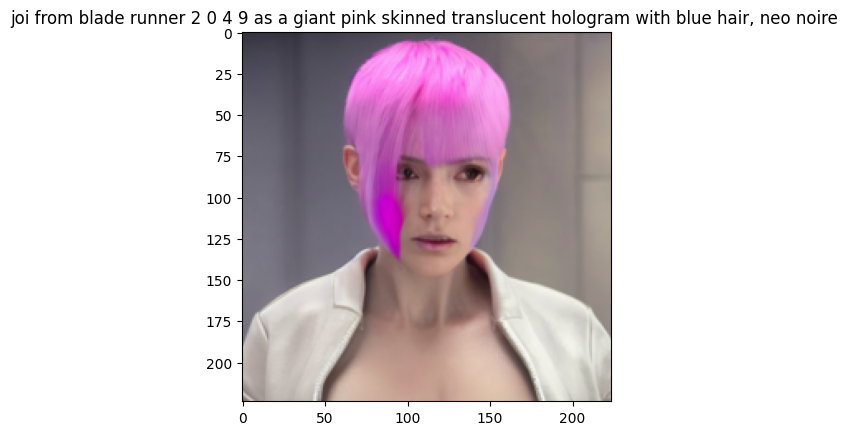

In [60]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.title(text_list[0])

In [61]:
n = int(0.9 * len(text_list))
train_text_data = text_list[:n]
valid_text_data= text_list[n:]
train_image_data = images[:n]
valid_image_data = images[n:]

#Making into batches of 20

In [62]:
def generate_batches(data, batch_size):

    num_batches = len(data) // batch_size
    batches = []


    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch_data = data[batch_start:batch_end]
        batches.append(batch_data)


    if len(data) % batch_size != 0:
        last_batch = data[num_batches * batch_size:]
        batches.append(last_batch)

    return batches

In [63]:
train_image_batches = generate_batches(train_image_data, 20)
test_text_batches = generate_batches(train_text_data, 20)

In [64]:
#Take classifier free guidance
cfg = list(df['cfg'])

In [65]:
cfg_train = cfg[:n]
cfg_test = cfg[n:]

In [66]:
cfg_train_batches = generate_batches(cfg_train, 20)
cfg_test_batches = generate_batches(cfg_test, 20)

**Let's start training process, but because of lack of computational power it is quite difficult for me to train the whole dataset**

In [67]:
from torch.nn import functional as F

In [68]:
num_iters = 10

def calculate_loss(images: torch.Tensor, targets: torch.Tensor):
    prediction = Discriminator(images.reshape(-1, 784))
    loss = F.binary_cross_entropy_with_logits(prediction, targets)
    return loss

In [ ]:
d_optimizer = torch.optim.AdamW(Discriminator().parameters(), lr=1.0e-4)

#VQ-GAN Training

In [78]:


@staticmethod
def adopt_weight(disc_factor, i, threshold, value=0.):
  if i<threshold:
    disc_factor = value
  return disc_factor


In [ ]:
for iter in range(num_iters):
  for i in range(1000):
    image = train_image_data[i].to(device)
    prompt = train_text_data[i].to(device)
    cgf = cfg_train[i]
    img, vq_loss = generate(prompt, input_image=image, uncond_prompt=None, strength=0.8, do_cfg=True, cfg_scale=cfg,
             sampler_name="ddpm", n_inference_steps=50, models={}, seed=None, device=None, idle_device=None, tokenizer=None)
    d_real = Discriminator(image)
    d_fake = Discriminator(img)
    d_loss_real = torch.mean(F.relu(1. - d_real))
    d_loss_fake = torch.mean(F.relu(1. + d_fake))
    disc_factor = adopt_weight(1, iter*1000+1, threshold=1000)
    gan_loss = disc_factor * 0.5*(d_loss_real + d_loss_fake)
    t_loss = calculate_loss(image, img)
    loss = t_loss + vq_loss + gan_loss
    loss.backward()
    d_optimizer.step()
  print(loss)





#Using the weights of pre-trained model
**In the mean time, I have used pretrained weight from hugging face to check whether my model works perfectly or not with high accuracy**

**Here, I was unable to train the whole program because of limited computational power, I will find some way to run my whole program in and it's in the progress, so let's wait sometime to complete this task.**

**After the training a detail explanation will be followed later with explanation of code for each line and the whole visualization of noise input and how text prompt guides it to generate image**

In [85]:


def load_from_standard_weights(input_file: str, device: str) -> dict[str, torch.Tensor]:

    original_model = torch.load(input_file, map_location=device, weights_only = False)["state_dict"]

    converted = {}
    converted['diffusion'] = {}
    converted['encoder'] = {}
    converted['decoder'] = {}
    converted['clip'] = {}

    converted['diffusion']['time_embedding.linear_1.weight'] = original_model['model.diffusion_model.time_embed.0.weight']
    converted['diffusion']['time_embedding.linear_1.bias'] = original_model['model.diffusion_model.time_embed.0.bias']
    converted['diffusion']['time_embedding.linear_2.weight'] = original_model['model.diffusion_model.time_embed.2.weight']
    converted['diffusion']['time_embedding.linear_2.bias'] = original_model['model.diffusion_model.time_embed.2.bias']
    converted['diffusion']['unet.encoders.0.0.weight'] = original_model['model.diffusion_model.input_blocks.0.0.weight']
    converted['diffusion']['unet.encoders.0.0.bias'] = original_model['model.diffusion_model.input_blocks.0.0.bias']
    converted['diffusion']['unet.encoders.1.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.1.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.1.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.1.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.1.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.1.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.1.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.1.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.1.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.1.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.1.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.1.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.1.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.1.1.norm.weight']
    converted['diffusion']['unet.encoders.1.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.1.1.norm.bias']
    converted['diffusion']['unet.encoders.1.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.1.1.proj_in.weight']
    converted['diffusion']['unet.encoders.1.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.1.1.proj_in.bias']
    converted['diffusion']['unet.encoders.1.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.1.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.1.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.1.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.1.1.proj_out.weight']
    converted['diffusion']['unet.encoders.1.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.1.1.proj_out.bias']
    converted['diffusion']['unet.encoders.2.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.2.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.2.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.2.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.2.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.2.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.2.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.2.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.2.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.2.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.2.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.2.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.2.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.2.1.norm.weight']
    converted['diffusion']['unet.encoders.2.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.2.1.norm.bias']
    converted['diffusion']['unet.encoders.2.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.2.1.proj_in.weight']
    converted['diffusion']['unet.encoders.2.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.2.1.proj_in.bias']
    converted['diffusion']['unet.encoders.2.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.2.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.2.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.2.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.2.1.proj_out.weight']
    converted['diffusion']['unet.encoders.2.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.2.1.proj_out.bias']
    converted['diffusion']['unet.encoders.3.0.weight'] = original_model['model.diffusion_model.input_blocks.3.0.op.weight']
    converted['diffusion']['unet.encoders.3.0.bias'] = original_model['model.diffusion_model.input_blocks.3.0.op.bias']
    converted['diffusion']['unet.encoders.4.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.4.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.4.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.4.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.4.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.4.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.4.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.4.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.4.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.4.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.4.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.4.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.4.0.residual_layer.weight'] = original_model['model.diffusion_model.input_blocks.4.0.skip_connection.weight']
    converted['diffusion']['unet.encoders.4.0.residual_layer.bias'] = original_model['model.diffusion_model.input_blocks.4.0.skip_connection.bias']
    converted['diffusion']['unet.encoders.4.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.4.1.norm.weight']
    converted['diffusion']['unet.encoders.4.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.4.1.norm.bias']
    converted['diffusion']['unet.encoders.4.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.4.1.proj_in.weight']
    converted['diffusion']['unet.encoders.4.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.4.1.proj_in.bias']
    converted['diffusion']['unet.encoders.4.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.4.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.4.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.4.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.4.1.proj_out.weight']
    converted['diffusion']['unet.encoders.4.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.4.1.proj_out.bias']
    converted['diffusion']['unet.encoders.5.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.5.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.5.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.5.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.5.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.5.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.5.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.5.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.5.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.5.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.5.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.5.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.5.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.5.1.norm.weight']
    converted['diffusion']['unet.encoders.5.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.5.1.norm.bias']
    converted['diffusion']['unet.encoders.5.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.5.1.proj_in.weight']
    converted['diffusion']['unet.encoders.5.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.5.1.proj_in.bias']
    converted['diffusion']['unet.encoders.5.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.5.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.5.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.5.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.5.1.proj_out.weight']
    converted['diffusion']['unet.encoders.5.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.5.1.proj_out.bias']
    converted['diffusion']['unet.encoders.6.0.weight'] = original_model['model.diffusion_model.input_blocks.6.0.op.weight']
    converted['diffusion']['unet.encoders.6.0.bias'] = original_model['model.diffusion_model.input_blocks.6.0.op.bias']
    converted['diffusion']['unet.encoders.7.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.7.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.7.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.7.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.7.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.7.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.7.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.7.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.7.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.7.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.7.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.7.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.7.0.residual_layer.weight'] = original_model['model.diffusion_model.input_blocks.7.0.skip_connection.weight']
    converted['diffusion']['unet.encoders.7.0.residual_layer.bias'] = original_model['model.diffusion_model.input_blocks.7.0.skip_connection.bias']
    converted['diffusion']['unet.encoders.7.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.7.1.norm.weight']
    converted['diffusion']['unet.encoders.7.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.7.1.norm.bias']
    converted['diffusion']['unet.encoders.7.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.7.1.proj_in.weight']
    converted['diffusion']['unet.encoders.7.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.7.1.proj_in.bias']
    converted['diffusion']['unet.encoders.7.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.7.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.7.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.7.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.7.1.proj_out.weight']
    converted['diffusion']['unet.encoders.7.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.7.1.proj_out.bias']
    converted['diffusion']['unet.encoders.8.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.8.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.8.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.8.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.8.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.8.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.8.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.8.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.8.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.8.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.8.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.8.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.8.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.8.1.norm.weight']
    converted['diffusion']['unet.encoders.8.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.8.1.norm.bias']
    converted['diffusion']['unet.encoders.8.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.8.1.proj_in.weight']
    converted['diffusion']['unet.encoders.8.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.8.1.proj_in.bias']
    converted['diffusion']['unet.encoders.8.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.8.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.8.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.8.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.8.1.proj_out.weight']
    converted['diffusion']['unet.encoders.8.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.8.1.proj_out.bias']
    converted['diffusion']['unet.encoders.9.0.weight'] = original_model['model.diffusion_model.input_blocks.9.0.op.weight']
    converted['diffusion']['unet.encoders.9.0.bias'] = original_model['model.diffusion_model.input_blocks.9.0.op.bias']
    converted['diffusion']['unet.encoders.10.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.10.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.10.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.10.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.10.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.10.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.10.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.10.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.10.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.10.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.10.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.10.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.11.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.11.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.11.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.11.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.11.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.11.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.11.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.11.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.11.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.11.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.11.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.11.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.3.bias']
    converted['diffusion']['unet.bottleneck.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.middle_block.0.in_layers.0.weight']
    converted['diffusion']['unet.bottleneck.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.middle_block.0.in_layers.0.bias']
    converted['diffusion']['unet.bottleneck.0.conv_feature.weight'] = original_model['model.diffusion_model.middle_block.0.in_layers.2.weight']
    converted['diffusion']['unet.bottleneck.0.conv_feature.bias'] = original_model['model.diffusion_model.middle_block.0.in_layers.2.bias']
    converted['diffusion']['unet.bottleneck.0.linear_time.weight'] = original_model['model.diffusion_model.middle_block.0.emb_layers.1.weight']
    converted['diffusion']['unet.bottleneck.0.linear_time.bias'] = original_model['model.diffusion_model.middle_block.0.emb_layers.1.bias']
    converted['diffusion']['unet.bottleneck.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.middle_block.0.out_layers.0.weight']
    converted['diffusion']['unet.bottleneck.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.middle_block.0.out_layers.0.bias']
    converted['diffusion']['unet.bottleneck.0.conv_merged.weight'] = original_model['model.diffusion_model.middle_block.0.out_layers.3.weight']
    converted['diffusion']['unet.bottleneck.0.conv_merged.bias'] = original_model['model.diffusion_model.middle_block.0.out_layers.3.bias']
    converted['diffusion']['unet.bottleneck.1.groupnorm.weight'] = original_model['model.diffusion_model.middle_block.1.norm.weight']
    converted['diffusion']['unet.bottleneck.1.groupnorm.bias'] = original_model['model.diffusion_model.middle_block.1.norm.bias']
    converted['diffusion']['unet.bottleneck.1.conv_input.weight'] = original_model['model.diffusion_model.middle_block.1.proj_in.weight']
    converted['diffusion']['unet.bottleneck.1.conv_input.bias'] = original_model['model.diffusion_model.middle_block.1.proj_in.bias']
    converted['diffusion']['unet.bottleneck.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.bottleneck.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.bottleneck.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_1.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_1.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_2.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_2.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_3.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_3.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.bottleneck.1.conv_output.weight'] = original_model['model.diffusion_model.middle_block.1.proj_out.weight']
    converted['diffusion']['unet.bottleneck.1.conv_output.bias'] = original_model['model.diffusion_model.middle_block.1.proj_out.bias']
    converted['diffusion']['unet.bottleneck.2.groupnorm_feature.weight'] = original_model['model.diffusion_model.middle_block.2.in_layers.0.weight']
    converted['diffusion']['unet.bottleneck.2.groupnorm_feature.bias'] = original_model['model.diffusion_model.middle_block.2.in_layers.0.bias']
    converted['diffusion']['unet.bottleneck.2.conv_feature.weight'] = original_model['model.diffusion_model.middle_block.2.in_layers.2.weight']
    converted['diffusion']['unet.bottleneck.2.conv_feature.bias'] = original_model['model.diffusion_model.middle_block.2.in_layers.2.bias']
    converted['diffusion']['unet.bottleneck.2.linear_time.weight'] = original_model['model.diffusion_model.middle_block.2.emb_layers.1.weight']
    converted['diffusion']['unet.bottleneck.2.linear_time.bias'] = original_model['model.diffusion_model.middle_block.2.emb_layers.1.bias']
    converted['diffusion']['unet.bottleneck.2.groupnorm_merged.weight'] = original_model['model.diffusion_model.middle_block.2.out_layers.0.weight']
    converted['diffusion']['unet.bottleneck.2.groupnorm_merged.bias'] = original_model['model.diffusion_model.middle_block.2.out_layers.0.bias']
    converted['diffusion']['unet.bottleneck.2.conv_merged.weight'] = original_model['model.diffusion_model.middle_block.2.out_layers.3.weight']
    converted['diffusion']['unet.bottleneck.2.conv_merged.bias'] = original_model['model.diffusion_model.middle_block.2.out_layers.3.bias']
    converted['diffusion']['unet.decoders.0.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.0.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.0.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.0.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.0.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.0.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.0.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.0.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.0.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.0.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.0.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.0.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.0.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.0.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.0.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.0.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.1.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.1.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.1.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.1.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.1.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.1.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.1.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.1.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.1.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.1.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.1.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.1.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.1.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.1.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.1.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.1.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.2.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.2.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.2.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.2.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.2.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.2.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.2.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.2.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.2.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.2.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.2.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.2.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.2.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.2.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.2.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.2.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.2.1.conv.weight'] = original_model['model.diffusion_model.output_blocks.2.1.conv.weight']
    converted['diffusion']['unet.decoders.2.1.conv.bias'] = original_model['model.diffusion_model.output_blocks.2.1.conv.bias']
    converted['diffusion']['unet.decoders.3.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.3.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.3.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.3.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.3.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.3.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.3.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.3.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.3.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.3.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.3.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.3.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.3.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.3.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.3.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.3.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.3.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.3.1.norm.weight']
    converted['diffusion']['unet.decoders.3.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.3.1.norm.bias']
    converted['diffusion']['unet.decoders.3.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.3.1.proj_in.weight']
    converted['diffusion']['unet.decoders.3.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.3.1.proj_in.bias']
    converted['diffusion']['unet.decoders.3.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.3.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.3.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.3.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.3.1.proj_out.weight']
    converted['diffusion']['unet.decoders.3.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.3.1.proj_out.bias']
    converted['diffusion']['unet.decoders.4.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.4.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.4.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.4.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.4.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.4.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.4.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.4.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.4.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.4.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.4.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.4.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.4.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.4.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.4.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.4.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.4.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.4.1.norm.weight']
    converted['diffusion']['unet.decoders.4.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.4.1.norm.bias']
    converted['diffusion']['unet.decoders.4.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.4.1.proj_in.weight']
    converted['diffusion']['unet.decoders.4.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.4.1.proj_in.bias']
    converted['diffusion']['unet.decoders.4.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.4.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.4.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.4.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.4.1.proj_out.weight']
    converted['diffusion']['unet.decoders.4.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.4.1.proj_out.bias']
    converted['diffusion']['unet.decoders.5.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.5.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.5.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.5.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.5.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.5.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.5.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.5.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.5.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.5.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.5.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.5.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.5.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.5.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.5.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.5.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.5.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.5.1.norm.weight']
    converted['diffusion']['unet.decoders.5.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.5.1.norm.bias']
    converted['diffusion']['unet.decoders.5.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.5.1.proj_in.weight']
    converted['diffusion']['unet.decoders.5.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.5.1.proj_in.bias']
    converted['diffusion']['unet.decoders.5.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.5.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.5.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.5.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.5.1.proj_out.weight']
    converted['diffusion']['unet.decoders.5.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.5.1.proj_out.bias']
    converted['diffusion']['unet.decoders.5.2.conv.weight'] = original_model['model.diffusion_model.output_blocks.5.2.conv.weight']
    converted['diffusion']['unet.decoders.5.2.conv.bias'] = original_model['model.diffusion_model.output_blocks.5.2.conv.bias']
    converted['diffusion']['unet.decoders.6.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.6.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.6.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.6.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.6.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.6.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.6.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.6.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.6.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.6.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.6.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.6.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.6.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.6.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.6.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.6.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.6.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.6.1.norm.weight']
    converted['diffusion']['unet.decoders.6.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.6.1.norm.bias']
    converted['diffusion']['unet.decoders.6.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.6.1.proj_in.weight']
    converted['diffusion']['unet.decoders.6.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.6.1.proj_in.bias']
    converted['diffusion']['unet.decoders.6.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.6.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.6.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.6.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.6.1.proj_out.weight']
    converted['diffusion']['unet.decoders.6.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.6.1.proj_out.bias']
    converted['diffusion']['unet.decoders.7.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.7.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.7.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.7.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.7.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.7.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.7.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.7.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.7.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.7.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.7.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.7.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.7.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.7.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.7.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.7.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.7.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.7.1.norm.weight']
    converted['diffusion']['unet.decoders.7.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.7.1.norm.bias']
    converted['diffusion']['unet.decoders.7.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.7.1.proj_in.weight']
    converted['diffusion']['unet.decoders.7.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.7.1.proj_in.bias']
    converted['diffusion']['unet.decoders.7.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.7.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.7.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.7.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.7.1.proj_out.weight']
    converted['diffusion']['unet.decoders.7.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.7.1.proj_out.bias']
    converted['diffusion']['unet.decoders.8.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.8.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.8.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.8.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.8.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.8.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.8.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.8.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.8.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.8.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.8.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.8.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.8.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.8.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.8.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.8.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.8.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.8.1.norm.weight']
    converted['diffusion']['unet.decoders.8.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.8.1.norm.bias']
    converted['diffusion']['unet.decoders.8.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.8.1.proj_in.weight']
    converted['diffusion']['unet.decoders.8.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.8.1.proj_in.bias']
    converted['diffusion']['unet.decoders.8.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.8.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.8.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.8.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.8.1.proj_out.weight']
    converted['diffusion']['unet.decoders.8.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.8.1.proj_out.bias']
    converted['diffusion']['unet.decoders.8.2.conv.weight'] = original_model['model.diffusion_model.output_blocks.8.2.conv.weight']
    converted['diffusion']['unet.decoders.8.2.conv.bias'] = original_model['model.diffusion_model.output_blocks.8.2.conv.bias']
    converted['diffusion']['unet.decoders.9.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.9.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.9.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.9.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.9.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.9.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.9.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.9.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.9.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.9.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.9.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.9.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.9.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.9.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.9.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.9.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.9.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.9.1.norm.weight']
    converted['diffusion']['unet.decoders.9.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.9.1.norm.bias']
    converted['diffusion']['unet.decoders.9.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.9.1.proj_in.weight']
    converted['diffusion']['unet.decoders.9.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.9.1.proj_in.bias']
    converted['diffusion']['unet.decoders.9.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.9.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.9.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.9.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.9.1.proj_out.weight']
    converted['diffusion']['unet.decoders.9.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.9.1.proj_out.bias']
    converted['diffusion']['unet.decoders.10.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.10.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.10.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.10.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.10.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.10.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.10.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.10.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.10.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.10.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.10.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.10.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.10.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.10.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.10.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.10.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.10.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.10.1.norm.weight']
    converted['diffusion']['unet.decoders.10.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.10.1.norm.bias']
    converted['diffusion']['unet.decoders.10.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.10.1.proj_in.weight']
    converted['diffusion']['unet.decoders.10.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.10.1.proj_in.bias']
    converted['diffusion']['unet.decoders.10.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.10.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.10.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.10.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.10.1.proj_out.weight']
    converted['diffusion']['unet.decoders.10.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.10.1.proj_out.bias']
    converted['diffusion']['unet.decoders.11.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.11.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.11.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.11.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.11.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.11.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.11.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.11.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.11.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.11.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.11.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.11.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.11.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.11.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.11.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.11.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.11.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.11.1.norm.weight']
    converted['diffusion']['unet.decoders.11.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.11.1.norm.bias']
    converted['diffusion']['unet.decoders.11.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.11.1.proj_in.weight']
    converted['diffusion']['unet.decoders.11.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.11.1.proj_in.bias']
    converted['diffusion']['unet.decoders.11.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.11.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.11.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.11.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.11.1.proj_out.weight']
    converted['diffusion']['unet.decoders.11.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.11.1.proj_out.bias']
    converted['diffusion']['final.groupnorm.weight'] = original_model['model.diffusion_model.out.0.weight']
    converted['diffusion']['final.groupnorm.bias'] = original_model['model.diffusion_model.out.0.bias']
    converted['diffusion']['final.conv.weight'] = original_model['model.diffusion_model.out.2.weight']
    converted['diffusion']['final.conv.bias'] = original_model['model.diffusion_model.out.2.bias']
    converted['encoder']['0.weight'] = original_model['first_stage_model.encoder.conv_in.weight']
    converted['encoder']['0.bias'] = original_model['first_stage_model.encoder.conv_in.bias']
    converted['encoder']['1.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.0.block.0.norm1.weight']
    converted['encoder']['1.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.0.block.0.norm1.bias']
    converted['encoder']['1.conv_1.weight'] = original_model['first_stage_model.encoder.down.0.block.0.conv1.weight']
    converted['encoder']['1.conv_1.bias'] = original_model['first_stage_model.encoder.down.0.block.0.conv1.bias']
    converted['encoder']['1.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.0.block.0.norm2.weight']
    converted['encoder']['1.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.0.block.0.norm2.bias']
    converted['encoder']['1.conv_2.weight'] = original_model['first_stage_model.encoder.down.0.block.0.conv2.weight']
    converted['encoder']['1.conv_2.bias'] = original_model['first_stage_model.encoder.down.0.block.0.conv2.bias']
    converted['encoder']['2.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.0.block.1.norm1.weight']
    converted['encoder']['2.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.0.block.1.norm1.bias']
    converted['encoder']['2.conv_1.weight'] = original_model['first_stage_model.encoder.down.0.block.1.conv1.weight']
    converted['encoder']['2.conv_1.bias'] = original_model['first_stage_model.encoder.down.0.block.1.conv1.bias']
    converted['encoder']['2.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.0.block.1.norm2.weight']
    converted['encoder']['2.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.0.block.1.norm2.bias']
    converted['encoder']['2.conv_2.weight'] = original_model['first_stage_model.encoder.down.0.block.1.conv2.weight']
    converted['encoder']['2.conv_2.bias'] = original_model['first_stage_model.encoder.down.0.block.1.conv2.bias']
    converted['encoder']['3.weight'] = original_model['first_stage_model.encoder.down.0.downsample.conv.weight']
    converted['encoder']['3.bias'] = original_model['first_stage_model.encoder.down.0.downsample.conv.bias']
    converted['encoder']['4.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.1.block.0.norm1.weight']
    converted['encoder']['4.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.1.block.0.norm1.bias']
    converted['encoder']['4.conv_1.weight'] = original_model['first_stage_model.encoder.down.1.block.0.conv1.weight']
    converted['encoder']['4.conv_1.bias'] = original_model['first_stage_model.encoder.down.1.block.0.conv1.bias']
    converted['encoder']['4.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.1.block.0.norm2.weight']
    converted['encoder']['4.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.1.block.0.norm2.bias']
    converted['encoder']['4.conv_2.weight'] = original_model['first_stage_model.encoder.down.1.block.0.conv2.weight']
    converted['encoder']['4.conv_2.bias'] = original_model['first_stage_model.encoder.down.1.block.0.conv2.bias']
    converted['encoder']['4.residual_layer.weight'] = original_model['first_stage_model.encoder.down.1.block.0.nin_shortcut.weight']
    converted['encoder']['4.residual_layer.bias'] = original_model['first_stage_model.encoder.down.1.block.0.nin_shortcut.bias']
    converted['encoder']['5.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.1.block.1.norm1.weight']
    converted['encoder']['5.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.1.block.1.norm1.bias']
    converted['encoder']['5.conv_1.weight'] = original_model['first_stage_model.encoder.down.1.block.1.conv1.weight']
    converted['encoder']['5.conv_1.bias'] = original_model['first_stage_model.encoder.down.1.block.1.conv1.bias']
    converted['encoder']['5.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.1.block.1.norm2.weight']
    converted['encoder']['5.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.1.block.1.norm2.bias']
    converted['encoder']['5.conv_2.weight'] = original_model['first_stage_model.encoder.down.1.block.1.conv2.weight']
    converted['encoder']['5.conv_2.bias'] = original_model['first_stage_model.encoder.down.1.block.1.conv2.bias']
    converted['encoder']['6.weight'] = original_model['first_stage_model.encoder.down.1.downsample.conv.weight']
    converted['encoder']['6.bias'] = original_model['first_stage_model.encoder.down.1.downsample.conv.bias']
    converted['encoder']['7.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.2.block.0.norm1.weight']
    converted['encoder']['7.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.2.block.0.norm1.bias']
    converted['encoder']['7.conv_1.weight'] = original_model['first_stage_model.encoder.down.2.block.0.conv1.weight']
    converted['encoder']['7.conv_1.bias'] = original_model['first_stage_model.encoder.down.2.block.0.conv1.bias']
    converted['encoder']['7.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.2.block.0.norm2.weight']
    converted['encoder']['7.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.2.block.0.norm2.bias']
    converted['encoder']['7.conv_2.weight'] = original_model['first_stage_model.encoder.down.2.block.0.conv2.weight']
    converted['encoder']['7.conv_2.bias'] = original_model['first_stage_model.encoder.down.2.block.0.conv2.bias']
    converted['encoder']['7.residual_layer.weight'] = original_model['first_stage_model.encoder.down.2.block.0.nin_shortcut.weight']
    converted['encoder']['7.residual_layer.bias'] = original_model['first_stage_model.encoder.down.2.block.0.nin_shortcut.bias']
    converted['encoder']['8.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.2.block.1.norm1.weight']
    converted['encoder']['8.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.2.block.1.norm1.bias']
    converted['encoder']['8.conv_1.weight'] = original_model['first_stage_model.encoder.down.2.block.1.conv1.weight']
    converted['encoder']['8.conv_1.bias'] = original_model['first_stage_model.encoder.down.2.block.1.conv1.bias']
    converted['encoder']['8.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.2.block.1.norm2.weight']
    converted['encoder']['8.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.2.block.1.norm2.bias']
    converted['encoder']['8.conv_2.weight'] = original_model['first_stage_model.encoder.down.2.block.1.conv2.weight']
    converted['encoder']['8.conv_2.bias'] = original_model['first_stage_model.encoder.down.2.block.1.conv2.bias']
    converted['encoder']['9.weight'] = original_model['first_stage_model.encoder.down.2.downsample.conv.weight']
    converted['encoder']['9.bias'] = original_model['first_stage_model.encoder.down.2.downsample.conv.bias']
    converted['encoder']['10.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.3.block.0.norm1.weight']
    converted['encoder']['10.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.3.block.0.norm1.bias']
    converted['encoder']['10.conv_1.weight'] = original_model['first_stage_model.encoder.down.3.block.0.conv1.weight']
    converted['encoder']['10.conv_1.bias'] = original_model['first_stage_model.encoder.down.3.block.0.conv1.bias']
    converted['encoder']['10.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.3.block.0.norm2.weight']
    converted['encoder']['10.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.3.block.0.norm2.bias']
    converted['encoder']['10.conv_2.weight'] = original_model['first_stage_model.encoder.down.3.block.0.conv2.weight']
    converted['encoder']['10.conv_2.bias'] = original_model['first_stage_model.encoder.down.3.block.0.conv2.bias']
    converted['encoder']['11.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.3.block.1.norm1.weight']
    converted['encoder']['11.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.3.block.1.norm1.bias']
    converted['encoder']['11.conv_1.weight'] = original_model['first_stage_model.encoder.down.3.block.1.conv1.weight']
    converted['encoder']['11.conv_1.bias'] = original_model['first_stage_model.encoder.down.3.block.1.conv1.bias']
    converted['encoder']['11.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.3.block.1.norm2.weight']
    converted['encoder']['11.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.3.block.1.norm2.bias']
    converted['encoder']['11.conv_2.weight'] = original_model['first_stage_model.encoder.down.3.block.1.conv2.weight']
    converted['encoder']['11.conv_2.bias'] = original_model['first_stage_model.encoder.down.3.block.1.conv2.bias']
    converted['encoder']['12.groupnorm_1.weight'] = original_model['first_stage_model.encoder.mid.block_1.norm1.weight']
    converted['encoder']['12.groupnorm_1.bias'] = original_model['first_stage_model.encoder.mid.block_1.norm1.bias']
    converted['encoder']['12.conv_1.weight'] = original_model['first_stage_model.encoder.mid.block_1.conv1.weight']
    converted['encoder']['12.conv_1.bias'] = original_model['first_stage_model.encoder.mid.block_1.conv1.bias']
    converted['encoder']['12.groupnorm_2.weight'] = original_model['first_stage_model.encoder.mid.block_1.norm2.weight']
    converted['encoder']['12.groupnorm_2.bias'] = original_model['first_stage_model.encoder.mid.block_1.norm2.bias']
    converted['encoder']['12.conv_2.weight'] = original_model['first_stage_model.encoder.mid.block_1.conv2.weight']
    converted['encoder']['12.conv_2.bias'] = original_model['first_stage_model.encoder.mid.block_1.conv2.bias']
    converted['encoder']['13.groupnorm.weight'] = original_model['first_stage_model.encoder.mid.attn_1.norm.weight']
    converted['encoder']['13.groupnorm.bias'] = original_model['first_stage_model.encoder.mid.attn_1.norm.bias']
    converted['encoder']['13.attention.out_proj.bias'] = original_model['first_stage_model.encoder.mid.attn_1.proj_out.bias']
    converted['encoder']['14.groupnorm_1.weight'] = original_model['first_stage_model.encoder.mid.block_2.norm1.weight']
    converted['encoder']['14.groupnorm_1.bias'] = original_model['first_stage_model.encoder.mid.block_2.norm1.bias']
    converted['encoder']['14.conv_1.weight'] = original_model['first_stage_model.encoder.mid.block_2.conv1.weight']
    converted['encoder']['14.conv_1.bias'] = original_model['first_stage_model.encoder.mid.block_2.conv1.bias']
    converted['encoder']['14.groupnorm_2.weight'] = original_model['first_stage_model.encoder.mid.block_2.norm2.weight']
    converted['encoder']['14.groupnorm_2.bias'] = original_model['first_stage_model.encoder.mid.block_2.norm2.bias']
    converted['encoder']['14.conv_2.weight'] = original_model['first_stage_model.encoder.mid.block_2.conv2.weight']
    converted['encoder']['14.conv_2.bias'] = original_model['first_stage_model.encoder.mid.block_2.conv2.bias']
    converted['encoder']['15.weight'] = original_model['first_stage_model.encoder.norm_out.weight']
    converted['encoder']['15.bias'] = original_model['first_stage_model.encoder.norm_out.bias']
    converted['encoder']['17.weight'] = original_model['first_stage_model.encoder.conv_out.weight']
    converted['encoder']['17.bias'] = original_model['first_stage_model.encoder.conv_out.bias']
    converted['decoder']['1.weight'] = original_model['first_stage_model.decoder.conv_in.weight']
    converted['decoder']['1.bias'] = original_model['first_stage_model.decoder.conv_in.bias']
    converted['decoder']['2.groupnorm_1.weight'] = original_model['first_stage_model.decoder.mid.block_1.norm1.weight']
    converted['decoder']['2.groupnorm_1.bias'] = original_model['first_stage_model.decoder.mid.block_1.norm1.bias']
    converted['decoder']['2.conv_1.weight'] = original_model['first_stage_model.decoder.mid.block_1.conv1.weight']
    converted['decoder']['2.conv_1.bias'] = original_model['first_stage_model.decoder.mid.block_1.conv1.bias']
    converted['decoder']['2.groupnorm_2.weight'] = original_model['first_stage_model.decoder.mid.block_1.norm2.weight']
    converted['decoder']['2.groupnorm_2.bias'] = original_model['first_stage_model.decoder.mid.block_1.norm2.bias']
    converted['decoder']['2.conv_2.weight'] = original_model['first_stage_model.decoder.mid.block_1.conv2.weight']
    converted['decoder']['2.conv_2.bias'] = original_model['first_stage_model.decoder.mid.block_1.conv2.bias']
    converted['decoder']['3.groupnorm.weight'] = original_model['first_stage_model.decoder.mid.attn_1.norm.weight']
    converted['decoder']['3.groupnorm.bias'] = original_model['first_stage_model.decoder.mid.attn_1.norm.bias']
    converted['decoder']['3.attention.out_proj.bias'] = original_model['first_stage_model.decoder.mid.attn_1.proj_out.bias']
    converted['decoder']['4.groupnorm_1.weight'] = original_model['first_stage_model.decoder.mid.block_2.norm1.weight']
    converted['decoder']['4.groupnorm_1.bias'] = original_model['first_stage_model.decoder.mid.block_2.norm1.bias']
    converted['decoder']['4.conv_1.weight'] = original_model['first_stage_model.decoder.mid.block_2.conv1.weight']
    converted['decoder']['4.conv_1.bias'] = original_model['first_stage_model.decoder.mid.block_2.conv1.bias']
    converted['decoder']['4.groupnorm_2.weight'] = original_model['first_stage_model.decoder.mid.block_2.norm2.weight']
    converted['decoder']['4.groupnorm_2.bias'] = original_model['first_stage_model.decoder.mid.block_2.norm2.bias']
    converted['decoder']['4.conv_2.weight'] = original_model['first_stage_model.decoder.mid.block_2.conv2.weight']
    converted['decoder']['4.conv_2.bias'] = original_model['first_stage_model.decoder.mid.block_2.conv2.bias']
    converted['decoder']['20.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.0.norm1.weight']
    converted['decoder']['20.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.0.norm1.bias']
    converted['decoder']['20.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.0.conv1.weight']
    converted['decoder']['20.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.0.conv1.bias']
    converted['decoder']['20.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.0.norm2.weight']
    converted['decoder']['20.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.0.norm2.bias']
    converted['decoder']['20.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.0.conv2.weight']
    converted['decoder']['20.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.0.conv2.bias']
    converted['decoder']['20.residual_layer.weight'] = original_model['first_stage_model.decoder.up.0.block.0.nin_shortcut.weight']
    converted['decoder']['20.residual_layer.bias'] = original_model['first_stage_model.decoder.up.0.block.0.nin_shortcut.bias']
    converted['decoder']['21.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.1.norm1.weight']
    converted['decoder']['21.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.1.norm1.bias']
    converted['decoder']['21.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.1.conv1.weight']
    converted['decoder']['21.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.1.conv1.bias']
    converted['decoder']['21.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.1.norm2.weight']
    converted['decoder']['21.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.1.norm2.bias']
    converted['decoder']['21.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.1.conv2.weight']
    converted['decoder']['21.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.1.conv2.bias']
    converted['decoder']['22.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.2.norm1.weight']
    converted['decoder']['22.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.2.norm1.bias']
    converted['decoder']['22.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.2.conv1.weight']
    converted['decoder']['22.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.2.conv1.bias']
    converted['decoder']['22.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.2.norm2.weight']
    converted['decoder']['22.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.2.norm2.bias']
    converted['decoder']['22.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.2.conv2.weight']
    converted['decoder']['22.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.2.conv2.bias']
    converted['decoder']['15.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.0.norm1.weight']
    converted['decoder']['15.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.0.norm1.bias']
    converted['decoder']['15.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.0.conv1.weight']
    converted['decoder']['15.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.0.conv1.bias']
    converted['decoder']['15.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.0.norm2.weight']
    converted['decoder']['15.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.0.norm2.bias']
    converted['decoder']['15.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.0.conv2.weight']
    converted['decoder']['15.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.0.conv2.bias']
    converted['decoder']['15.residual_layer.weight'] = original_model['first_stage_model.decoder.up.1.block.0.nin_shortcut.weight']
    converted['decoder']['15.residual_layer.bias'] = original_model['first_stage_model.decoder.up.1.block.0.nin_shortcut.bias']
    converted['decoder']['16.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.1.norm1.weight']
    converted['decoder']['16.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.1.norm1.bias']
    converted['decoder']['16.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.1.conv1.weight']
    converted['decoder']['16.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.1.conv1.bias']
    converted['decoder']['16.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.1.norm2.weight']
    converted['decoder']['16.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.1.norm2.bias']
    converted['decoder']['16.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.1.conv2.weight']
    converted['decoder']['16.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.1.conv2.bias']
    converted['decoder']['17.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.2.norm1.weight']
    converted['decoder']['17.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.2.norm1.bias']
    converted['decoder']['17.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.2.conv1.weight']
    converted['decoder']['17.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.2.conv1.bias']
    converted['decoder']['17.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.2.norm2.weight']
    converted['decoder']['17.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.2.norm2.bias']
    converted['decoder']['17.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.2.conv2.weight']
    converted['decoder']['17.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.2.conv2.bias']
    converted['decoder']['19.weight'] = original_model['first_stage_model.decoder.up.1.upsample.conv.weight']
    converted['decoder']['19.bias'] = original_model['first_stage_model.decoder.up.1.upsample.conv.bias']
    converted['decoder']['10.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.0.norm1.weight']
    converted['decoder']['10.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.0.norm1.bias']
    converted['decoder']['10.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.0.conv1.weight']
    converted['decoder']['10.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.0.conv1.bias']
    converted['decoder']['10.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.0.norm2.weight']
    converted['decoder']['10.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.0.norm2.bias']
    converted['decoder']['10.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.0.conv2.weight']
    converted['decoder']['10.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.0.conv2.bias']
    converted['decoder']['11.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.1.norm1.weight']
    converted['decoder']['11.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.1.norm1.bias']
    converted['decoder']['11.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.1.conv1.weight']
    converted['decoder']['11.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.1.conv1.bias']
    converted['decoder']['11.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.1.norm2.weight']
    converted['decoder']['11.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.1.norm2.bias']
    converted['decoder']['11.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.1.conv2.weight']
    converted['decoder']['11.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.1.conv2.bias']
    converted['decoder']['12.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.2.norm1.weight']
    converted['decoder']['12.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.2.norm1.bias']
    converted['decoder']['12.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.2.conv1.weight']
    converted['decoder']['12.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.2.conv1.bias']
    converted['decoder']['12.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.2.norm2.weight']
    converted['decoder']['12.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.2.norm2.bias']
    converted['decoder']['12.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.2.conv2.weight']
    converted['decoder']['12.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.2.conv2.bias']
    converted['decoder']['14.weight'] = original_model['first_stage_model.decoder.up.2.upsample.conv.weight']
    converted['decoder']['14.bias'] = original_model['first_stage_model.decoder.up.2.upsample.conv.bias']
    converted['decoder']['5.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.0.norm1.weight']
    converted['decoder']['5.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.0.norm1.bias']
    converted['decoder']['5.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.0.conv1.weight']
    converted['decoder']['5.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.0.conv1.bias']
    converted['decoder']['5.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.0.norm2.weight']
    converted['decoder']['5.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.0.norm2.bias']
    converted['decoder']['5.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.0.conv2.weight']
    converted['decoder']['5.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.0.conv2.bias']
    converted['decoder']['6.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.1.norm1.weight']
    converted['decoder']['6.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.1.norm1.bias']
    converted['decoder']['6.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.1.conv1.weight']
    converted['decoder']['6.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.1.conv1.bias']
    converted['decoder']['6.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.1.norm2.weight']
    converted['decoder']['6.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.1.norm2.bias']
    converted['decoder']['6.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.1.conv2.weight']
    converted['decoder']['6.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.1.conv2.bias']
    converted['decoder']['7.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.2.norm1.weight']
    converted['decoder']['7.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.2.norm1.bias']
    converted['decoder']['7.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.2.conv1.weight']
    converted['decoder']['7.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.2.conv1.bias']
    converted['decoder']['7.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.2.norm2.weight']
    converted['decoder']['7.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.2.norm2.bias']
    converted['decoder']['7.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.2.conv2.weight']
    converted['decoder']['7.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.2.conv2.bias']
    converted['decoder']['9.weight'] = original_model['first_stage_model.decoder.up.3.upsample.conv.weight']
    converted['decoder']['9.bias'] = original_model['first_stage_model.decoder.up.3.upsample.conv.bias']
    converted['decoder']['23.weight'] = original_model['first_stage_model.decoder.norm_out.weight']
    converted['decoder']['23.bias'] = original_model['first_stage_model.decoder.norm_out.bias']
    converted['decoder']['25.weight'] = original_model['first_stage_model.decoder.conv_out.weight']
    converted['decoder']['25.bias'] = original_model['first_stage_model.decoder.conv_out.bias']
    converted['encoder']['18.weight'] = original_model['first_stage_model.quant_conv.weight']
    converted['encoder']['18.bias'] = original_model['first_stage_model.quant_conv.bias']
    converted['decoder']['0.weight'] = original_model['first_stage_model.post_quant_conv.weight']
    converted['decoder']['0.bias'] = original_model['first_stage_model.post_quant_conv.bias']
    converted['clip']['embedding.token_embedding.weight'] = original_model['cond_stage_model.transformer.text_model.embeddings.token_embedding.weight']
    converted['clip']['embedding.position_embedding'] = original_model['cond_stage_model.transformer.text_model.embeddings.position_embedding.weight']
    converted['clip']['layers.0.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.weight']
    converted['clip']['layers.0.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.bias']
    converted['clip']['layers.0.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.weight']
    converted['clip']['layers.0.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.bias']
    converted['clip']['layers.0.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.weight']
    converted['clip']['layers.0.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.bias']
    converted['clip']['layers.0.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.weight']
    converted['clip']['layers.0.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.bias']
    converted['clip']['layers.0.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.weight']
    converted['clip']['layers.0.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.bias']
    converted['clip']['layers.1.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.weight']
    converted['clip']['layers.1.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.bias']
    converted['clip']['layers.1.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.weight']
    converted['clip']['layers.1.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.bias']
    converted['clip']['layers.1.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.weight']
    converted['clip']['layers.1.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.bias']
    converted['clip']['layers.1.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.weight']
    converted['clip']['layers.1.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.bias']
    converted['clip']['layers.1.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.weight']
    converted['clip']['layers.1.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.bias']
    converted['clip']['layers.2.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.weight']
    converted['clip']['layers.2.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.bias']
    converted['clip']['layers.2.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.weight']
    converted['clip']['layers.2.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.bias']
    converted['clip']['layers.2.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.weight']
    converted['clip']['layers.2.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.bias']
    converted['clip']['layers.2.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.weight']
    converted['clip']['layers.2.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.bias']
    converted['clip']['layers.2.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.weight']
    converted['clip']['layers.2.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.bias']
    converted['clip']['layers.3.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.weight']
    converted['clip']['layers.3.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.bias']
    converted['clip']['layers.3.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.weight']
    converted['clip']['layers.3.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.bias']
    converted['clip']['layers.3.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.weight']
    converted['clip']['layers.3.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.bias']
    converted['clip']['layers.3.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.weight']
    converted['clip']['layers.3.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.bias']
    converted['clip']['layers.3.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.weight']
    converted['clip']['layers.3.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.bias']
    converted['clip']['layers.4.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.weight']
    converted['clip']['layers.4.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.bias']
    converted['clip']['layers.4.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.weight']
    converted['clip']['layers.4.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.bias']
    converted['clip']['layers.4.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.weight']
    converted['clip']['layers.4.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.bias']
    converted['clip']['layers.4.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.weight']
    converted['clip']['layers.4.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.bias']
    converted['clip']['layers.4.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.weight']
    converted['clip']['layers.4.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.bias']
    converted['clip']['layers.5.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.weight']
    converted['clip']['layers.5.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.bias']
    converted['clip']['layers.5.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.weight']
    converted['clip']['layers.5.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.bias']
    converted['clip']['layers.5.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.weight']
    converted['clip']['layers.5.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.bias']
    converted['clip']['layers.5.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.weight']
    converted['clip']['layers.5.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.bias']
    converted['clip']['layers.5.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.weight']
    converted['clip']['layers.5.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.bias']
    converted['clip']['layers.6.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.weight']
    converted['clip']['layers.6.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.bias']
    converted['clip']['layers.6.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.weight']
    converted['clip']['layers.6.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.bias']
    converted['clip']['layers.6.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.weight']
    converted['clip']['layers.6.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.bias']
    converted['clip']['layers.6.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.weight']
    converted['clip']['layers.6.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.bias']
    converted['clip']['layers.6.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.weight']
    converted['clip']['layers.6.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.bias']
    converted['clip']['layers.7.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.weight']
    converted['clip']['layers.7.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.bias']
    converted['clip']['layers.7.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.weight']
    converted['clip']['layers.7.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.bias']
    converted['clip']['layers.7.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.weight']
    converted['clip']['layers.7.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.bias']
    converted['clip']['layers.7.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.weight']
    converted['clip']['layers.7.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.bias']
    converted['clip']['layers.7.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.weight']
    converted['clip']['layers.7.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.bias']
    converted['clip']['layers.8.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.weight']
    converted['clip']['layers.8.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.bias']
    converted['clip']['layers.8.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.weight']
    converted['clip']['layers.8.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.bias']
    converted['clip']['layers.8.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.weight']
    converted['clip']['layers.8.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.bias']
    converted['clip']['layers.8.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.weight']
    converted['clip']['layers.8.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.bias']
    converted['clip']['layers.8.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.weight']
    converted['clip']['layers.8.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.bias']
    converted['clip']['layers.9.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.weight']
    converted['clip']['layers.9.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.bias']
    converted['clip']['layers.9.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.weight']
    converted['clip']['layers.9.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.bias']
    converted['clip']['layers.9.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.weight']
    converted['clip']['layers.9.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.bias']
    converted['clip']['layers.9.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.weight']
    converted['clip']['layers.9.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.bias']
    converted['clip']['layers.9.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.weight']
    converted['clip']['layers.9.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.bias']
    converted['clip']['layers.10.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.weight']
    converted['clip']['layers.10.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.bias']
    converted['clip']['layers.10.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.weight']
    converted['clip']['layers.10.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.bias']
    converted['clip']['layers.10.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.weight']
    converted['clip']['layers.10.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.bias']
    converted['clip']['layers.10.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.weight']
    converted['clip']['layers.10.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.bias']
    converted['clip']['layers.10.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.weight']
    converted['clip']['layers.10.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.bias']
    converted['clip']['layers.11.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.weight']
    converted['clip']['layers.11.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.bias']
    converted['clip']['layers.11.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.weight']
    converted['clip']['layers.11.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.bias']
    converted['clip']['layers.11.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.weight']
    converted['clip']['layers.11.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.bias']
    converted['clip']['layers.11.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.weight']
    converted['clip']['layers.11.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.bias']
    converted['clip']['layers.11.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.weight']
    converted['clip']['layers.11.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.bias']
    converted['clip']['layernorm.weight'] = original_model['cond_stage_model.transformer.text_model.final_layer_norm.weight']
    converted['clip']['layernorm.bias'] = original_model['cond_stage_model.transformer.text_model.final_layer_norm.bias']
    converted['diffusion']['unet.encoders.1.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.2.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.4.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.5.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.7.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.8.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.bottleneck.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.3.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.4.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.5.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.6.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.7.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.8.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.9.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.10.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.11.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['encoder']['13.attention.in_proj.weight'] = torch.cat((original_model['first_stage_model.encoder.mid.attn_1.q.weight'], original_model['first_stage_model.encoder.mid.attn_1.k.weight'], original_model['first_stage_model.encoder.mid.attn_1.v.weight']), 0).reshape((1536, 512))
    converted['encoder']['13.attention.in_proj.bias'] = torch.cat((original_model['first_stage_model.encoder.mid.attn_1.q.bias'], original_model['first_stage_model.encoder.mid.attn_1.k.bias'], original_model['first_stage_model.encoder.mid.attn_1.v.bias']), 0)
    converted['encoder']['13.attention.out_proj.weight'] = original_model['first_stage_model.encoder.mid.attn_1.proj_out.weight'].reshape((512, 512))
    converted['decoder']['3.attention.in_proj.weight'] = torch.cat((original_model['first_stage_model.decoder.mid.attn_1.q.weight'], original_model['first_stage_model.decoder.mid.attn_1.k.weight'], original_model['first_stage_model.decoder.mid.attn_1.v.weight']), 0).reshape((1536, 512))
    converted['decoder']['3.attention.in_proj.bias'] = torch.cat((original_model['first_stage_model.decoder.mid.attn_1.q.bias'], original_model['first_stage_model.decoder.mid.attn_1.k.bias'], original_model['first_stage_model.decoder.mid.attn_1.v.bias']), 0)
    converted['decoder']['3.attention.out_proj.weight'] = original_model['first_stage_model.decoder.mid.attn_1.proj_out.weight'].reshape((512, 512))
    converted['clip']['layers.0.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.0.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.1.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.1.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.2.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.2.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.3.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.3.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.4.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.4.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.5.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.5.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.6.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.6.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.7.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.7.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.8.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.8.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.9.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.9.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.10.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.10.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.11.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.11.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.bias']), 0)

    return converted

In [84]:
model_file = "../data/v1-5-pruned-emaonly.ckpt"           #This file should be downloaded from the hugging face in our system, consisting of all the weights
models = load_from_standard_weights(model_file, device)

SyntaxError: invalid syntax (<ipython-input-84-cb0944feed47>, line 1)

In [ ]:
sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = generate(
    prompt=text_list[0],

    input_image=image[0],

    cfg_scale=cfg[0],
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,

    idle_device="cuda"

)
